In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.functional import F

from tqdm.notebook import trange

import matplotlib.pyplot as plt

In [3]:
from ode import ODEnetSimple
from models import ConvAE
from utils import add_spatial_encoding

In [4]:
# import the moving MNIST datatset
pathDataset = "data/MOVING_MNIST/mnist_test_seq_resized.npy"
moving_mnist = np.load(pathDataset)
moving_mnist = moving_mnist.reshape(-1, 1, 28, 28)
moving_mnist = moving_mnist.astype(np.float32)
moving_mnist = (moving_mnist - moving_mnist.min()) / (moving_mnist.max() - moving_mnist.min())
moving_mnist = [(image, 0) for image in moving_mnist]
moving_mnist = add_spatial_encoding(moving_mnist)
moving_mnist = np.array([image for image, _ in moving_mnist])
moving_mnist = moving_mnist.reshape(20, -1, 3, 28, 28)
print(moving_mnist.shape)

(20, 10000, 3, 28, 28)


In [5]:
pathAE = "models/AE/ae_moving_MNIST_with_sp_latent_128.pth"

# Separetly

In [6]:
ode = ODEnetSimple(out_dim=128, mid_dim=256)

Number of parameters: 131712


In [7]:
# import the model
model = ConvAE(height=28, width=28, in_channels=3, latent_dim=128)
model.load_state_dict(torch.load(pathAE))

Number of parameters in the model: 513443


<All keys matched successfully>

In [8]:
encoded_moving_mnist = model.encode(torch.tensor(moving_mnist.reshape(-1, 3, 28, 28)).float()).reshape(20, 10000, 128).detach().numpy()
print(encoded_moving_mnist.shape)

(20, 10000, 128)


(200, 128)
(20, 10, 128)


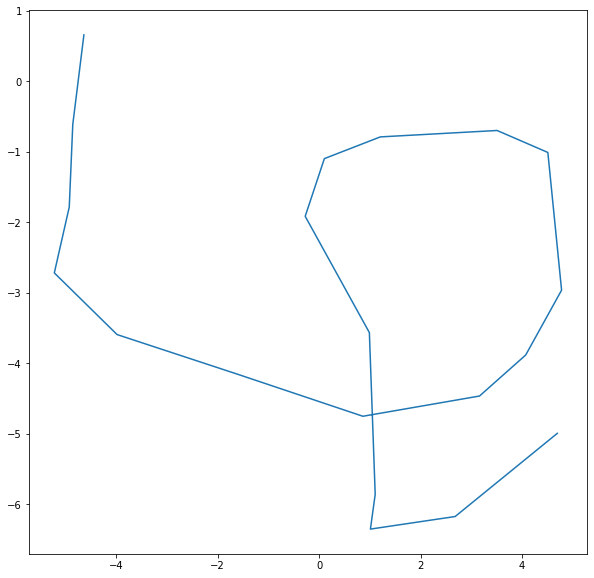

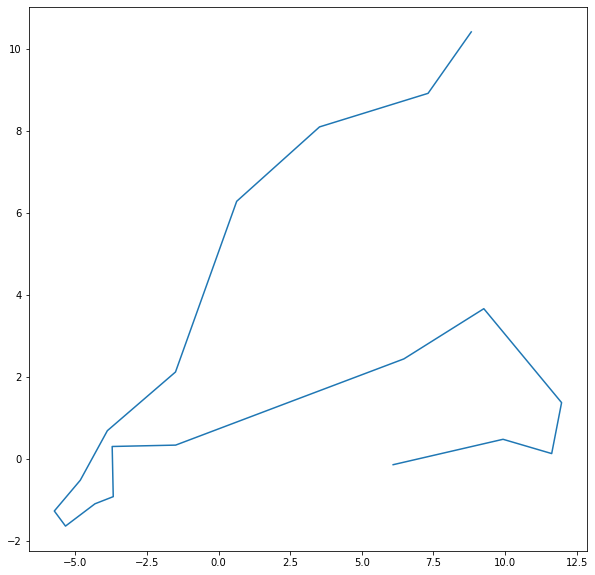

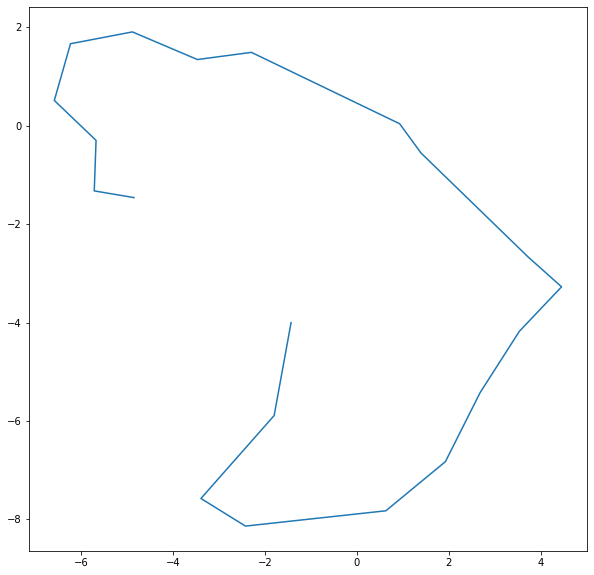

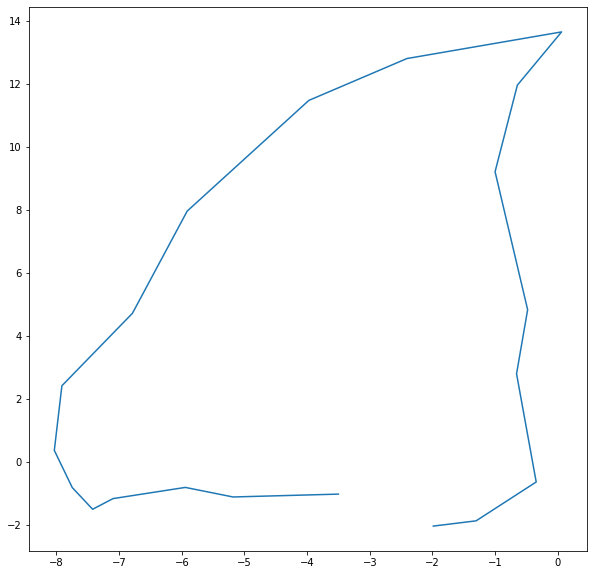

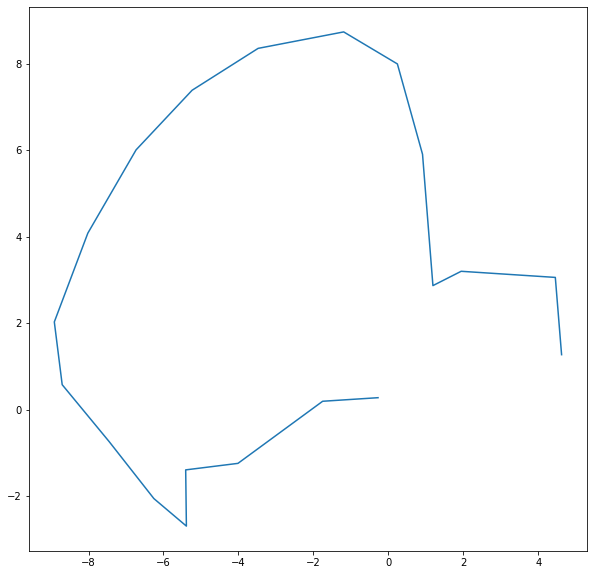

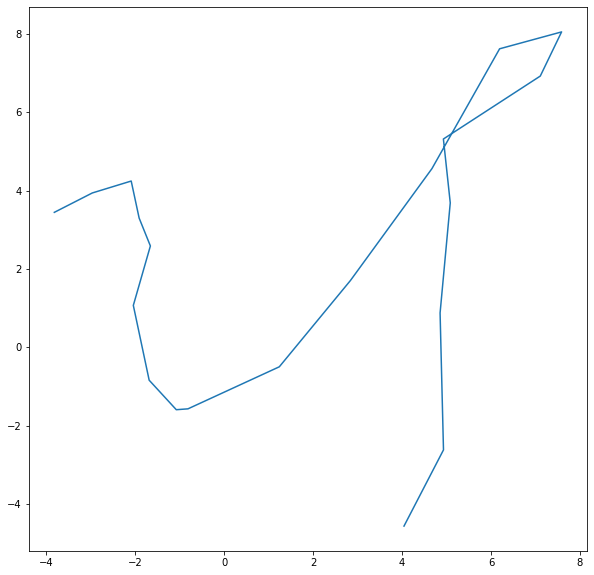

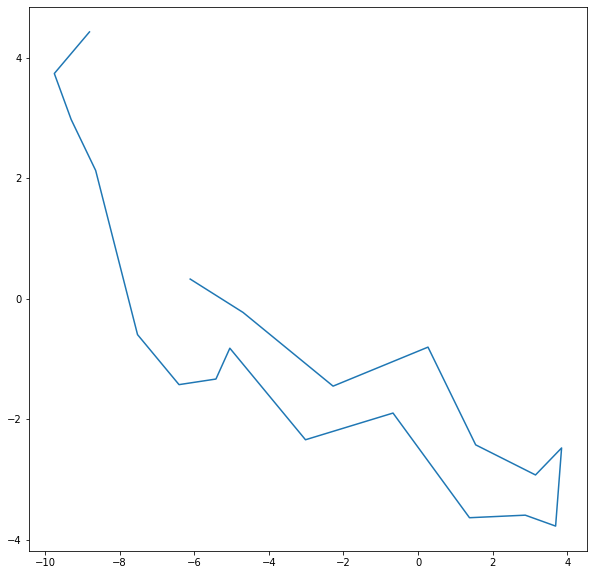

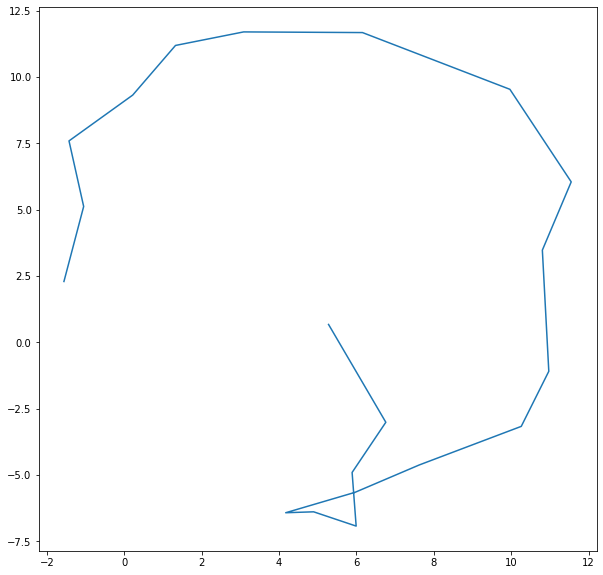

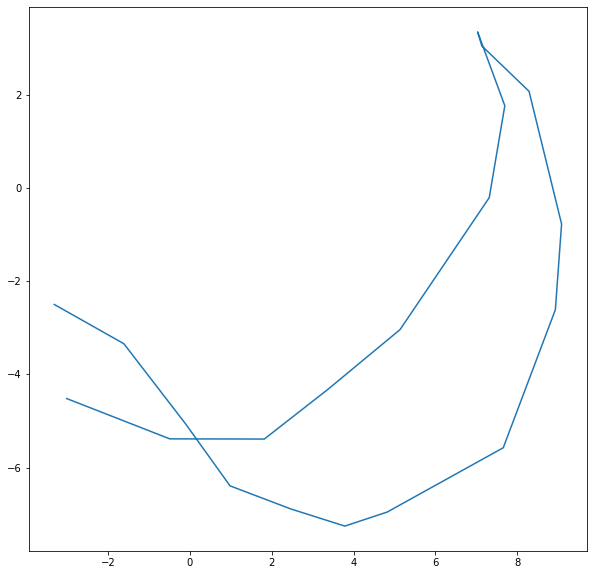

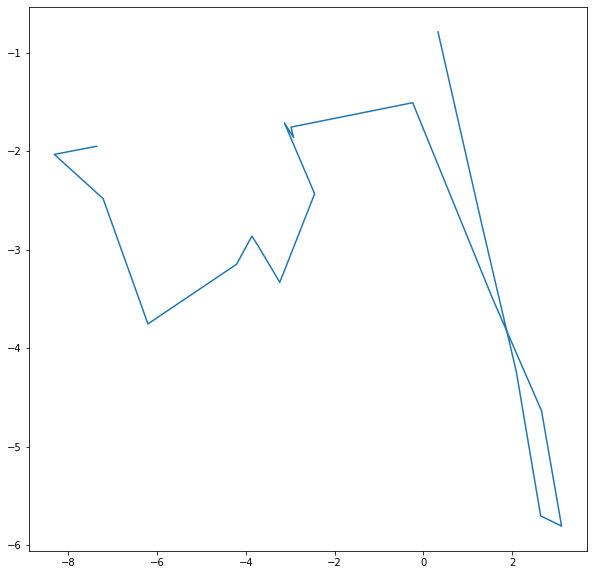

In [19]:
# plot trajectory inside the latent space
from sklearn import decomposition

bound = 10

pca = decomposition.PCA(n_components=2)
print(encoded_moving_mnist[:, :bound].reshape(-1, 128).shape)
print(encoded_moving_mnist[:, :bound].shape)
positions_transformed = pca.fit_transform(encoded_moving_mnist[:, :bound].reshape(-1, 128)).reshape(20, -1, 2)

for index in range(bound):
# transformation of the data in the index
# with the PCA
    position_transformed = positions_transformed[:, index]


    plt.figure(figsize=(10, 10))
    plt.plot(position_transformed[:, 0], position_transformed[:, 1], '-')
    plt.show()

In [10]:
from ode import train, ODEnetSimple

In [11]:
class BatchGetter:
    def __init__(self, batch_time, n_samples, total_length, dt, positions, frac_train):
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        self.true_positions = torch.tensor(positions, dtype=torch.float64).float()
        self.N_train = int(positions.shape[1]*frac_train)
        self.N_test = int(positions.shape[1]*(1-frac_train))
        self.N_train_image = int(positions.shape[0])
        self.dim = positions.shape[-1]

        self.train_times = self.times
        self.test_times = self.times
        self.train_positions = self.true_positions[:, :self.N_train]
        self.test_positions = self.true_positions[:, self.N_train:]

        print(self.train_positions.shape)
        # print(self.train_positions.shape)


        self.n_samples = n_samples
        self.batch_time = batch_time
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        trajectory_index = np.random.randint(self.N_train)
        # print(trajectory_index)
        s = torch.from_numpy(np.random.choice(np.arange(self.N_train_image - self.batch_time, dtype=np.int64), self.n_samples, replace=False))
        # print(s)
        batch_y0 = self.train_positions[s, trajectory_index]  # (M, D)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_y = torch.stack([self.train_positions[s + i, trajectory_index] for i in range(self.batch_time)], dim=0)  # (T, M, D)
        return batch_y0, batch_t, batch_y

dt = 0.05
batch_time = 10
n_samples = 10

getter = BatchGetter(batch_time, n_samples, encoded_moving_mnist.shape[0], dt, encoded_moving_mnist, 0.05)

torch.Size([20, 500, 128])


In [88]:
batch_y0, batch_t, batch_y = getter.get_batch()
print(batch_y0.shape, batch_t.shape, batch_y.shape)

torch.Size([10, 128]) torch.Size([10]) torch.Size([10, 10, 128])


In [89]:
getter.train_positions.shape

torch.Size([20, 8000, 128])

In [90]:
getter.train_positions[0, 0].unsqueeze(0).shape

torch.Size([1, 128])

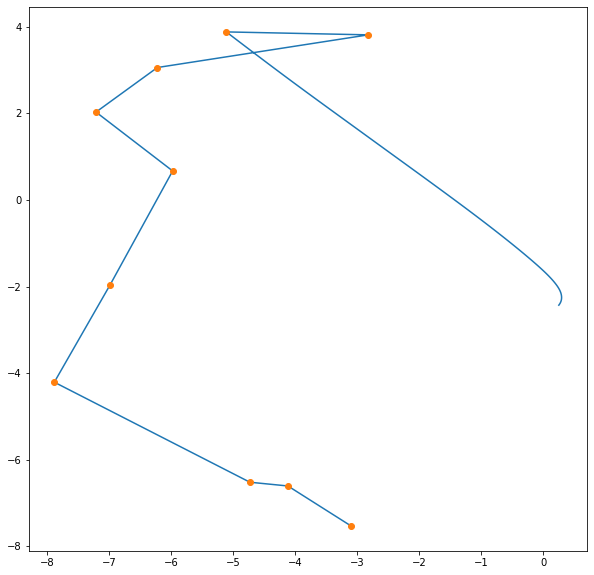

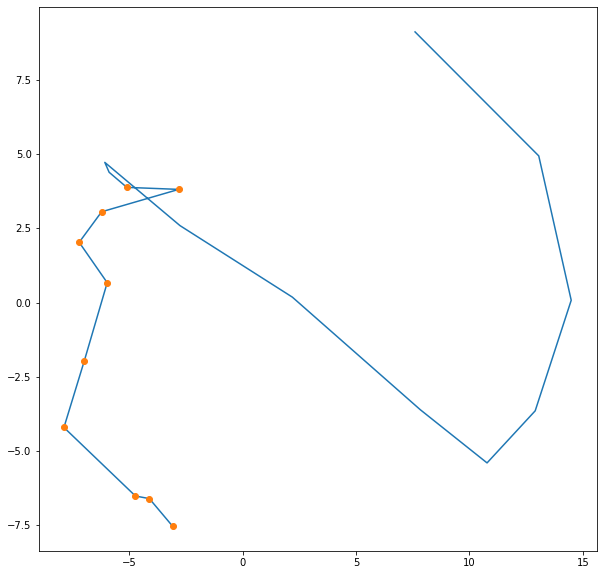

In [23]:
def display_results(model, getter):
    index = torch.randint(low=0, high=getter.N_train_image, size=(1,)).item()
    pca = decomposition.PCA(n_components=2)
    positions_transformed = pca.fit_transform(encoded_moving_mnist[:, index])

    times = torch.linspace(0., 1., int(1/0.01), dtype=torch.float64).float()
    
    predicted_output = model(getter.train_positions[:10, index], times).squeeze()[:, -1]
    predicted_output = torch.cat([getter.train_positions[:10, index], predicted_output ])
    # print(predicted_output.shape)
    transformed_predicted_output = pca.transform(predicted_output.detach().numpy())

    plt.figure(figsize=(10, 10))
    plt.plot(transformed_predicted_output[:, 0], transformed_predicted_output[:, 1], '-')
    plt.plot(transformed_predicted_output[:10, 0], transformed_predicted_output[:10, 1], 'o')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(positions_transformed[:, 0], positions_transformed[:, 1], '-')
    plt.plot(transformed_predicted_output[:10, 0], transformed_predicted_output[:10, 1], 'o')
    plt.show()

    



def train(model, optimizer, scheduler, epochs, batch_size, getter, display=100):
    
    model.train()
    iterator = trange(1, epochs+1)
    # just for the plot part
    for i in iterator:
        
        loss = 0.
        for _ in range(batch_size):
            # get a random time sample
            batch_init_positions, batch_times, batch_true_positions = getter.get_batch()
            # compute the output of the model
            out = model(batch_init_positions, batch_times)
            # compute the loss
            loss += 100*F.mse_loss(out[:].view(-1,getter.dim), batch_true_positions[:].view(-1,getter.dim))
        loss/=batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.8f}')

        if i % display == 0:
            print("-"*30, f"Epoch {i}", "-"*30)
            display_results(model, getter)

        scheduler.step()
        
    return None

display_results(ode, getter)

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------------------ Epoch 30 ------------------------------


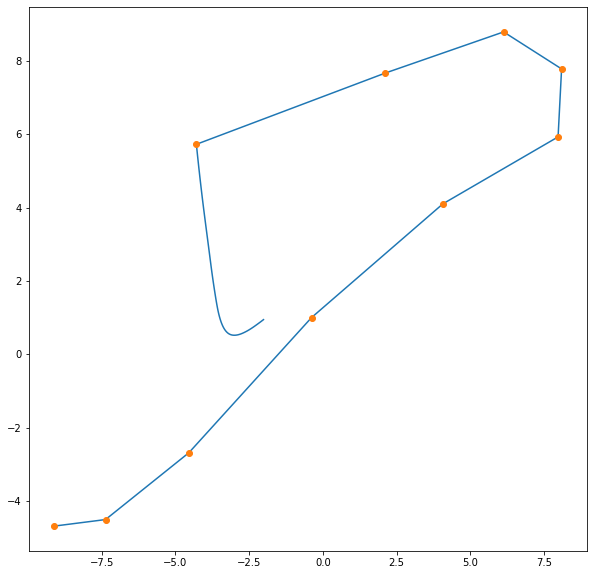

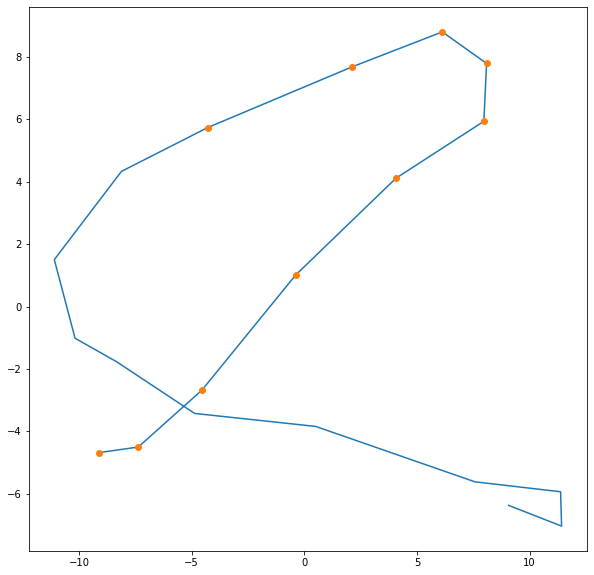

------------------------------ Epoch 60 ------------------------------


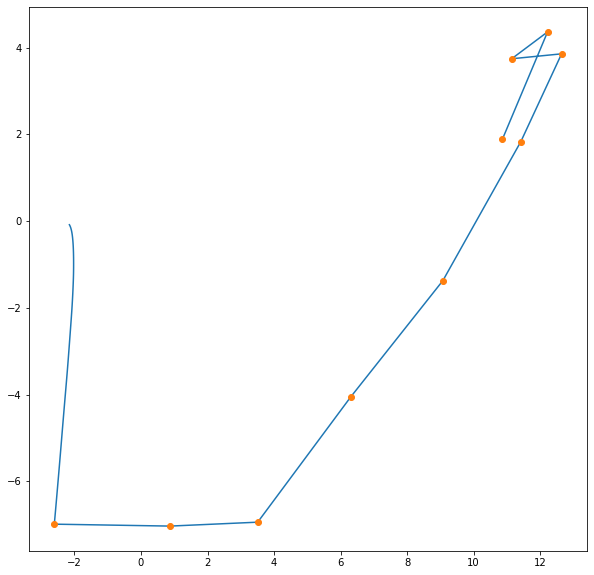

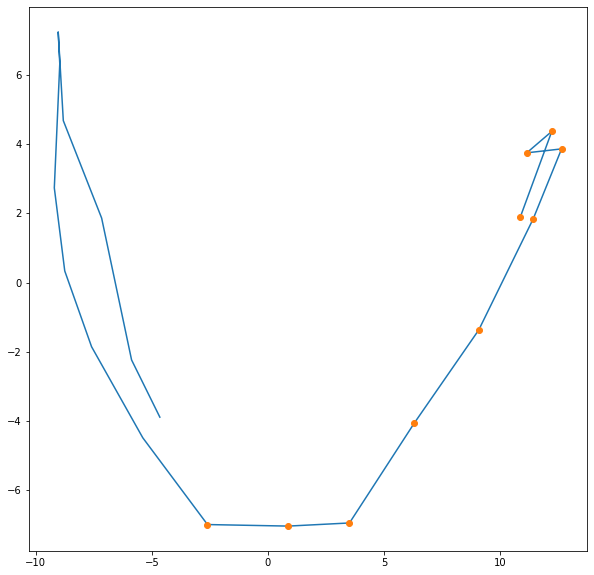

------------------------------ Epoch 90 ------------------------------


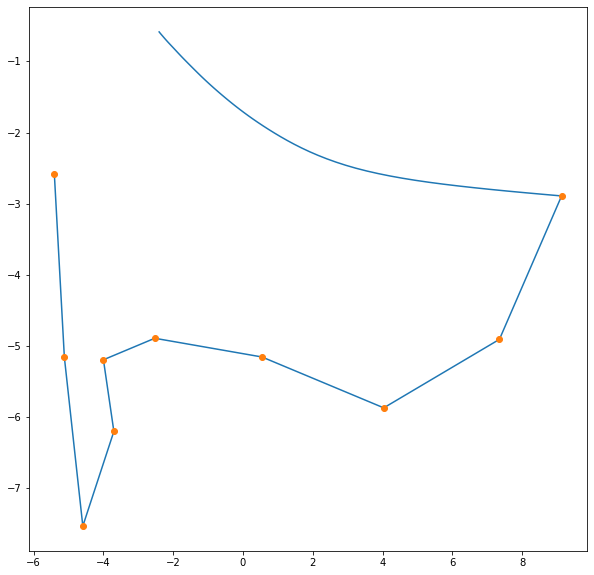

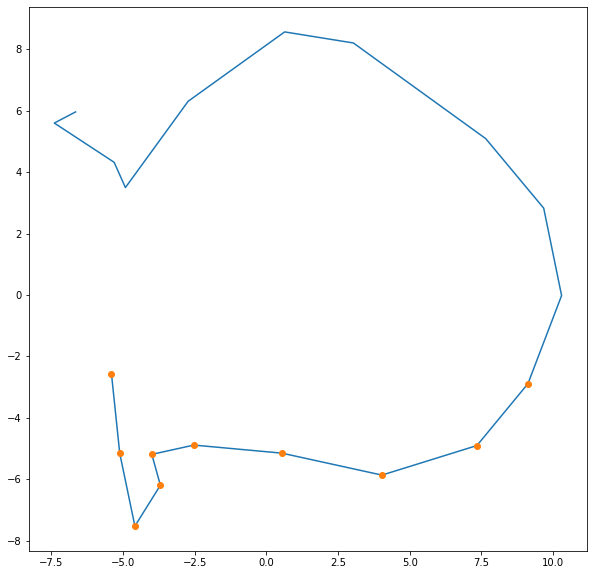

------------------------------ Epoch 120 ------------------------------


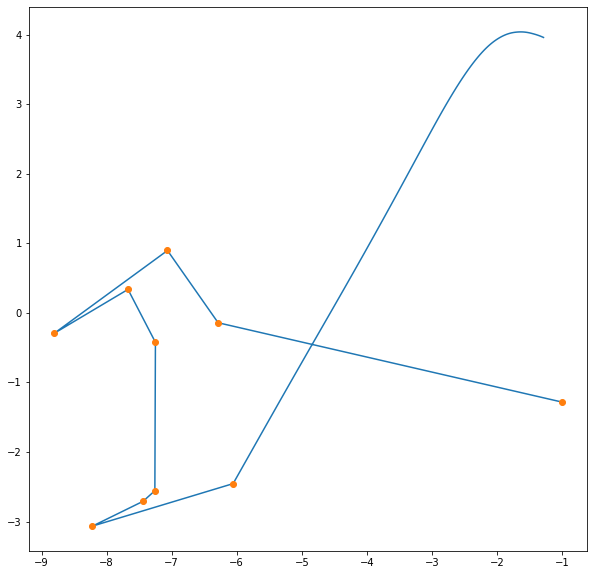

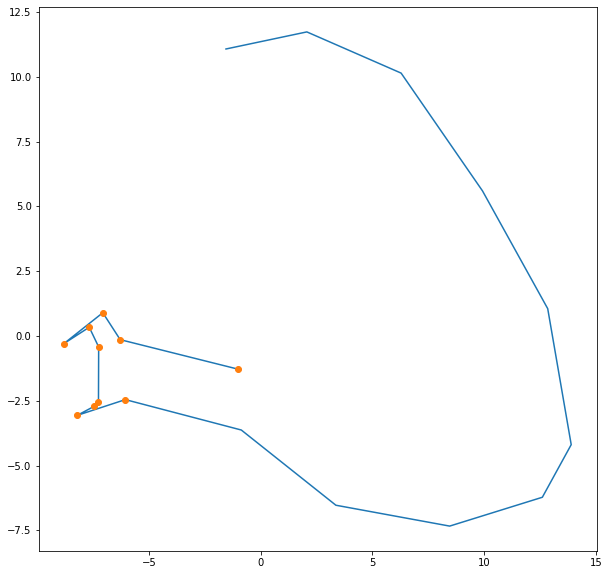

------------------------------ Epoch 150 ------------------------------


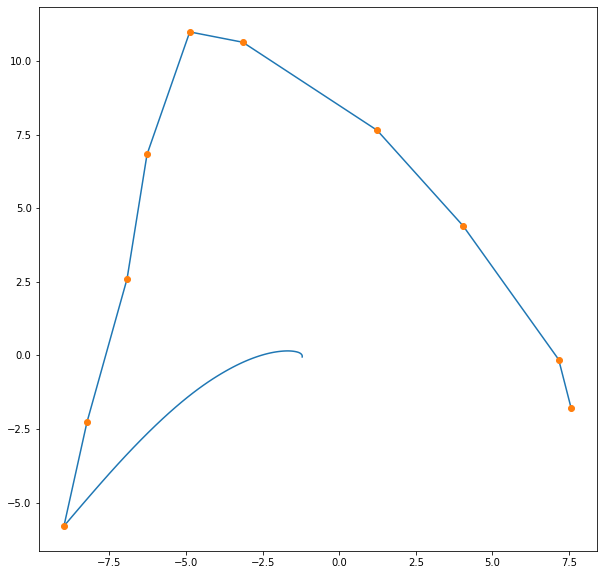

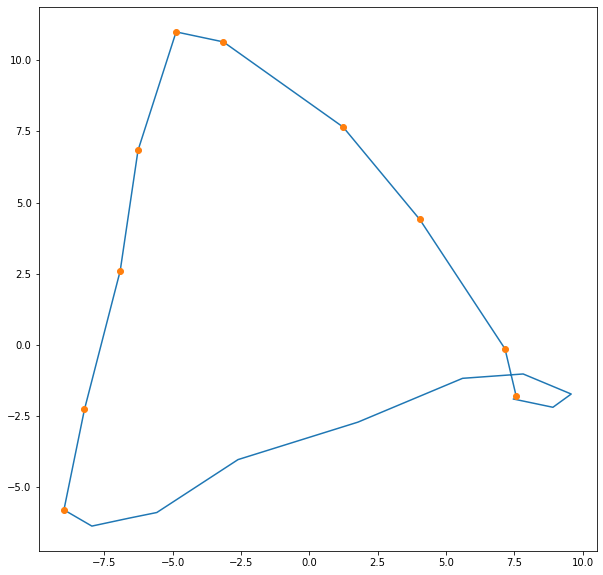

------------------------------ Epoch 180 ------------------------------


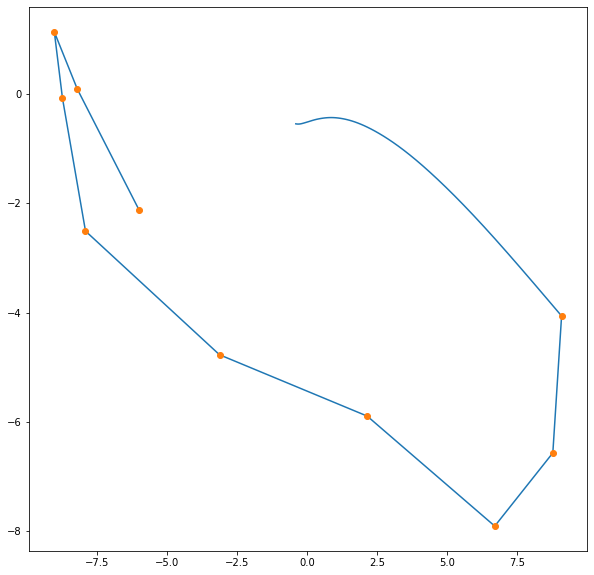

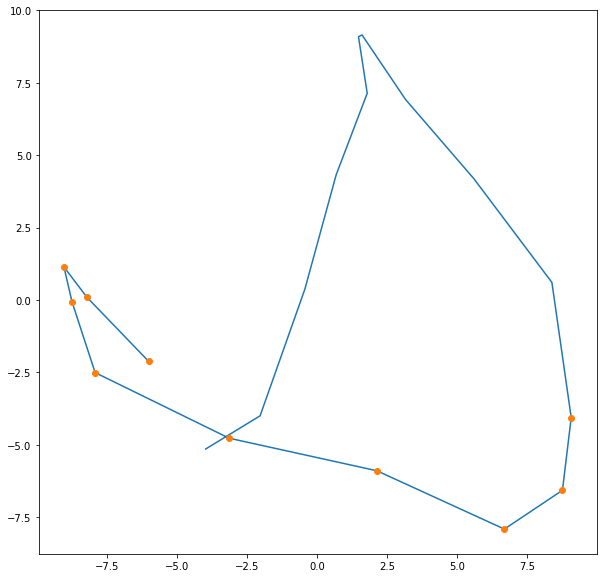

------------------------------ Epoch 210 ------------------------------


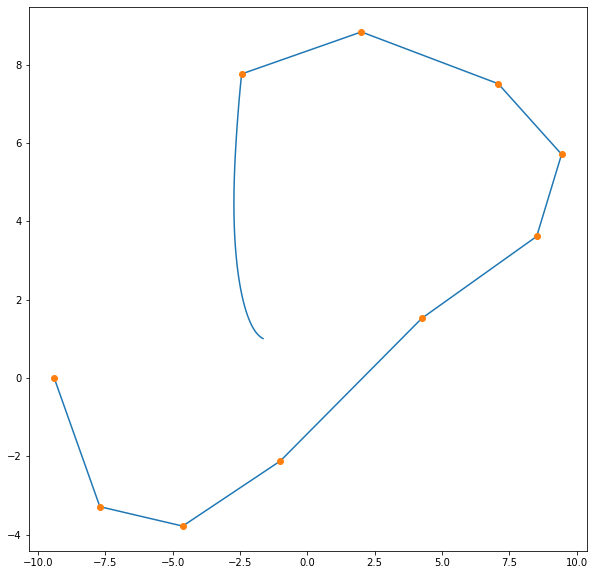

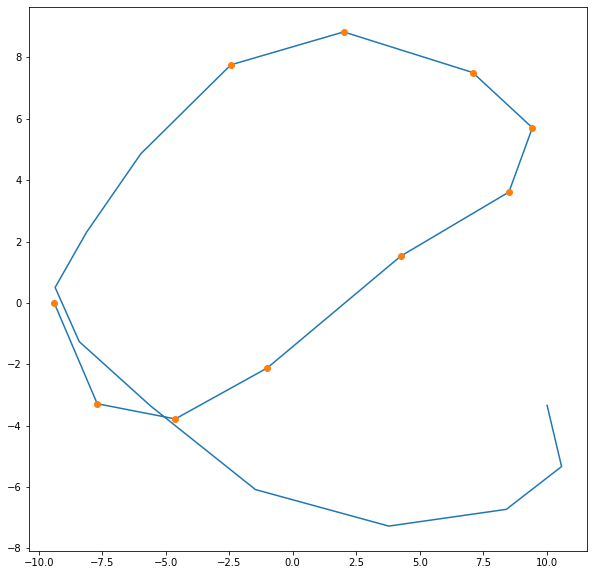

------------------------------ Epoch 240 ------------------------------


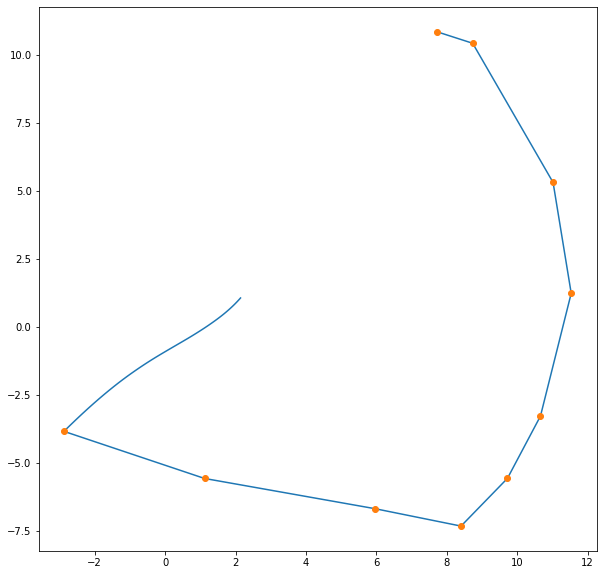

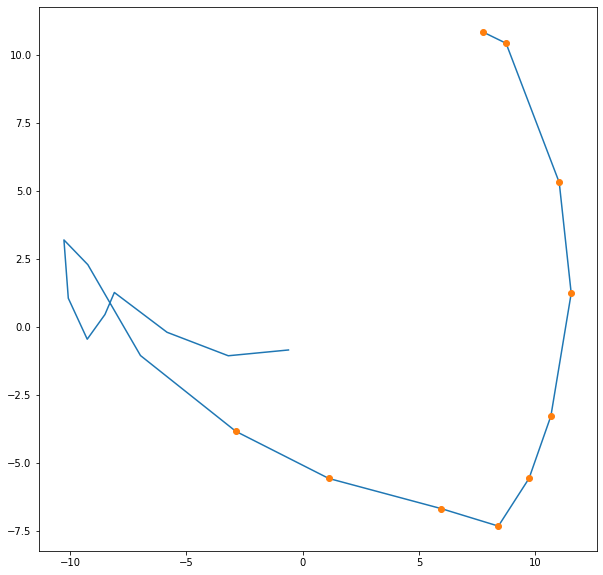

------------------------------ Epoch 270 ------------------------------


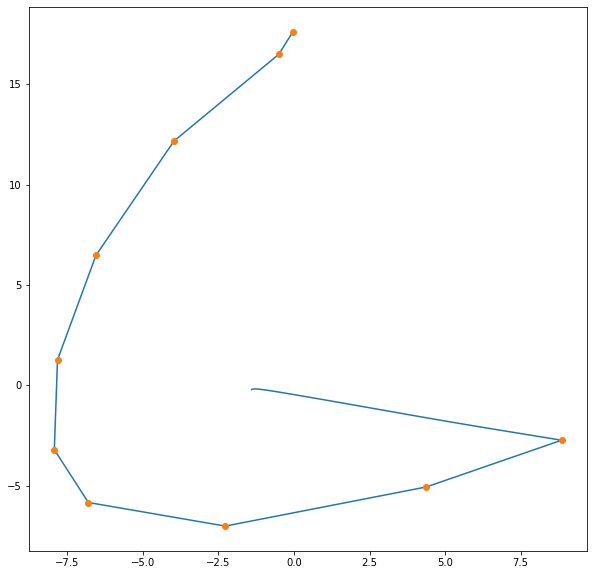

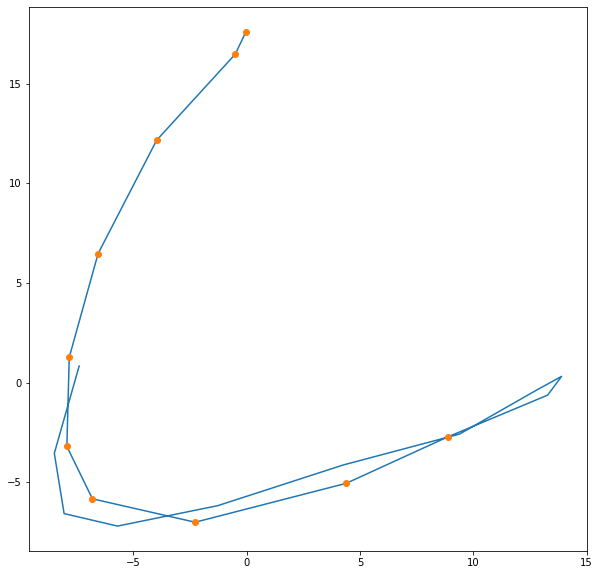

------------------------------ Epoch 300 ------------------------------


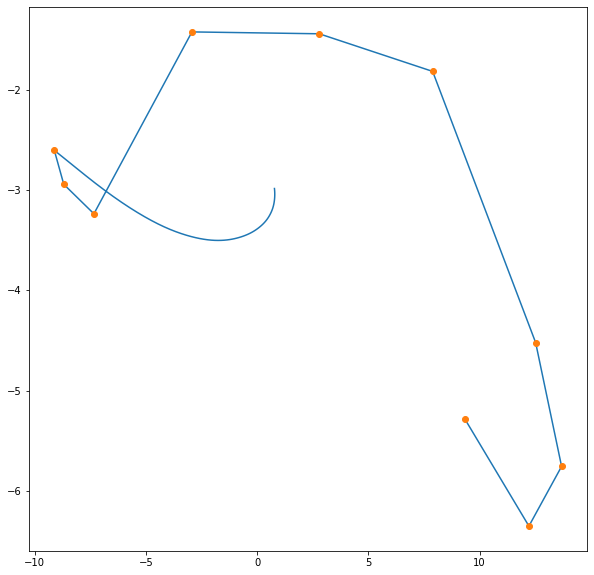

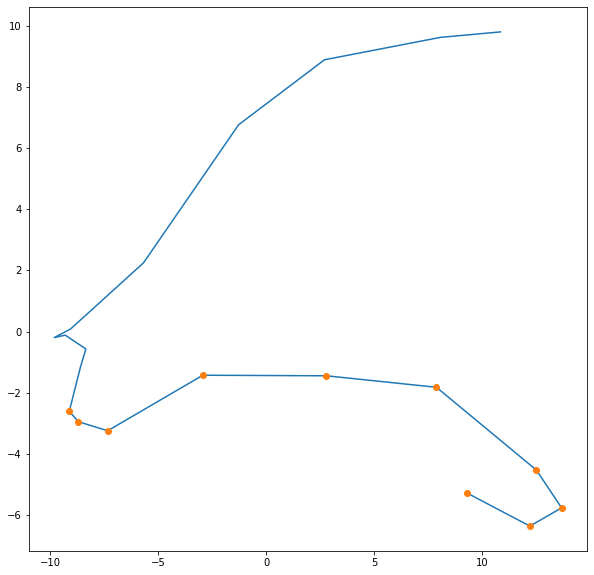

------------------------------ Epoch 330 ------------------------------


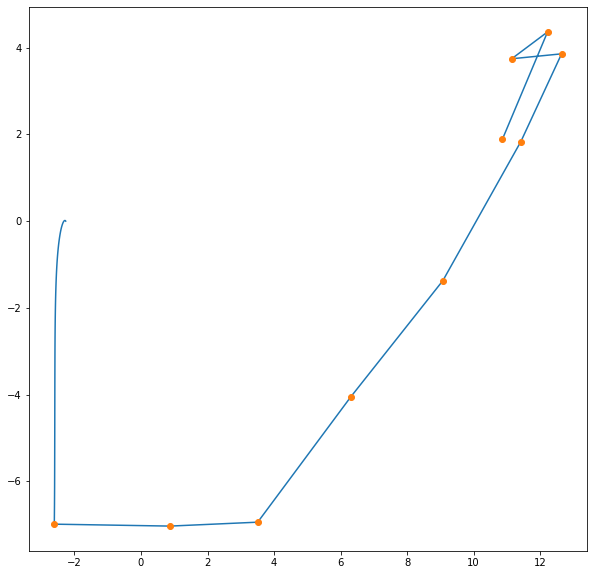

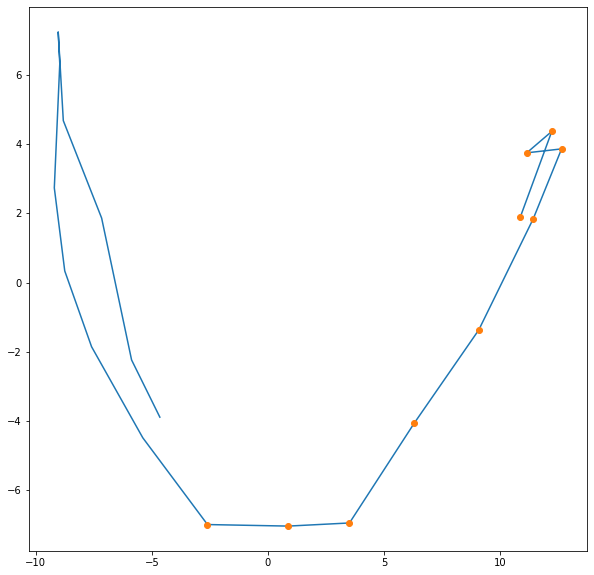

------------------------------ Epoch 360 ------------------------------


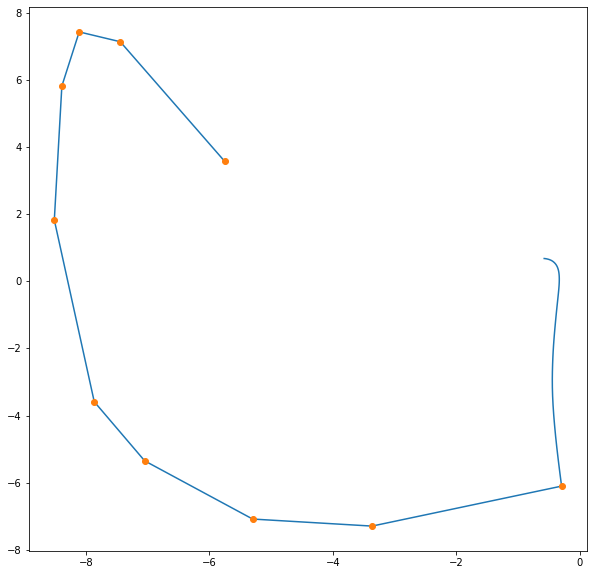

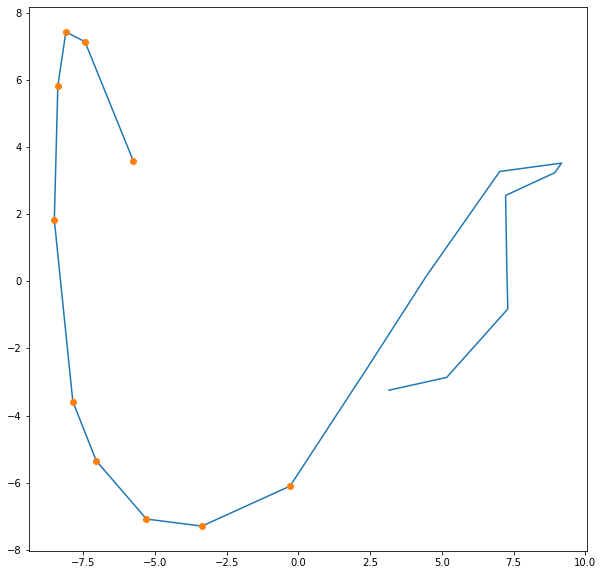

------------------------------ Epoch 390 ------------------------------


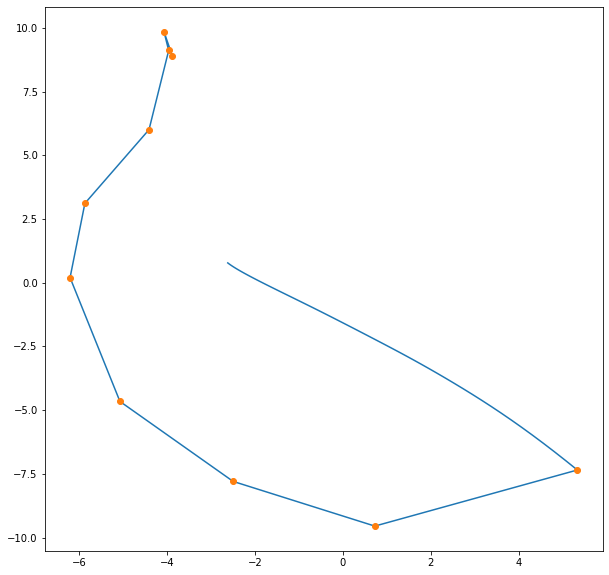

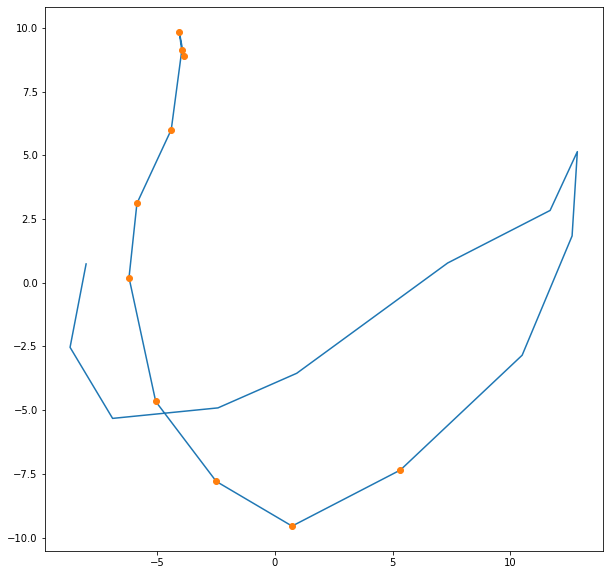

------------------------------ Epoch 420 ------------------------------


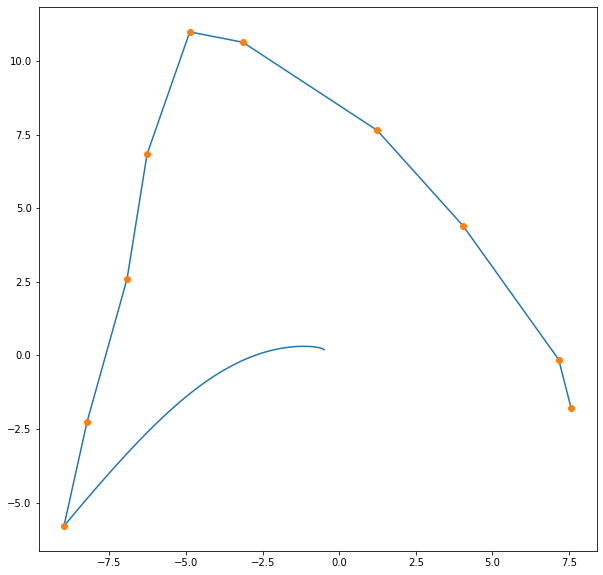

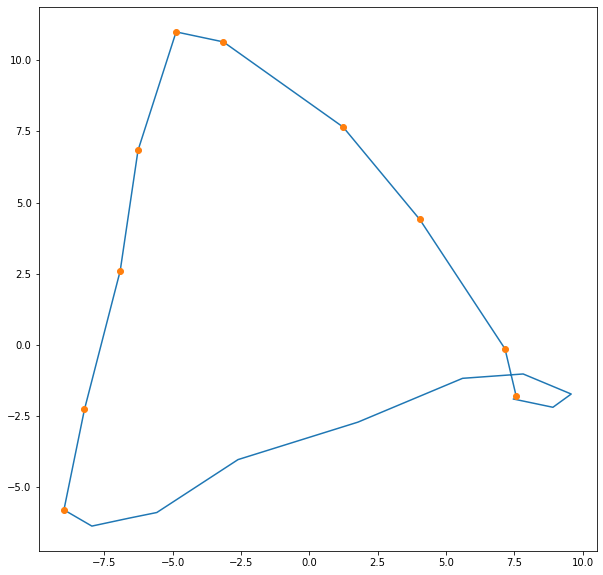

------------------------------ Epoch 450 ------------------------------


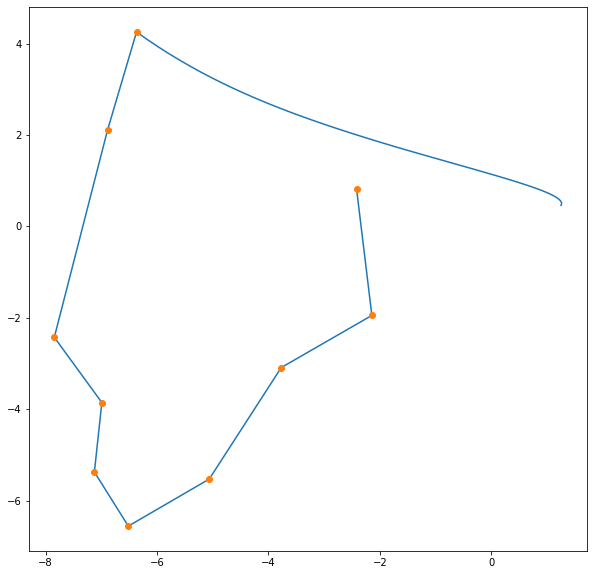

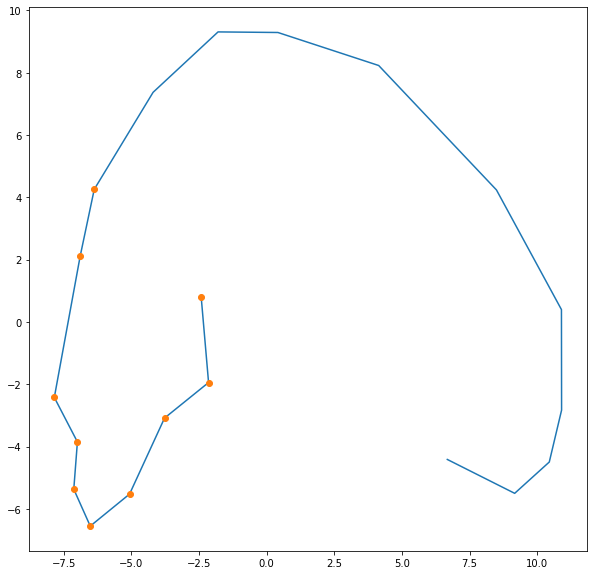

------------------------------ Epoch 480 ------------------------------


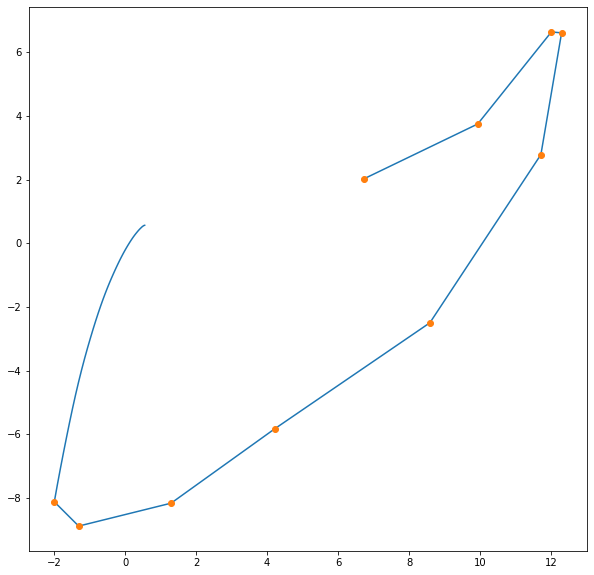

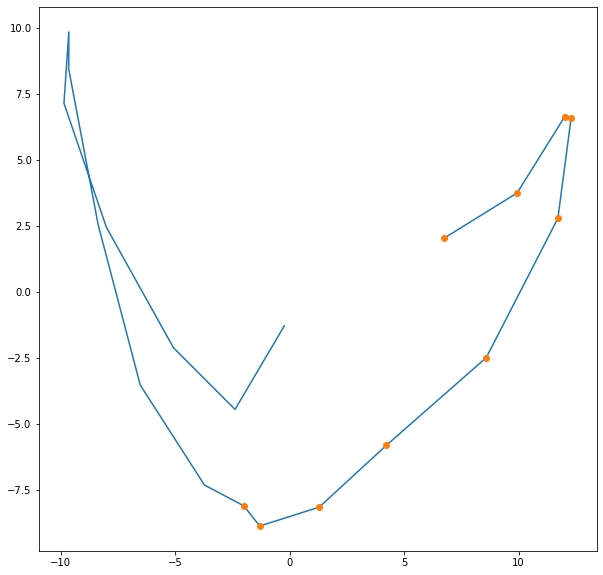

------------------------------ Epoch 510 ------------------------------


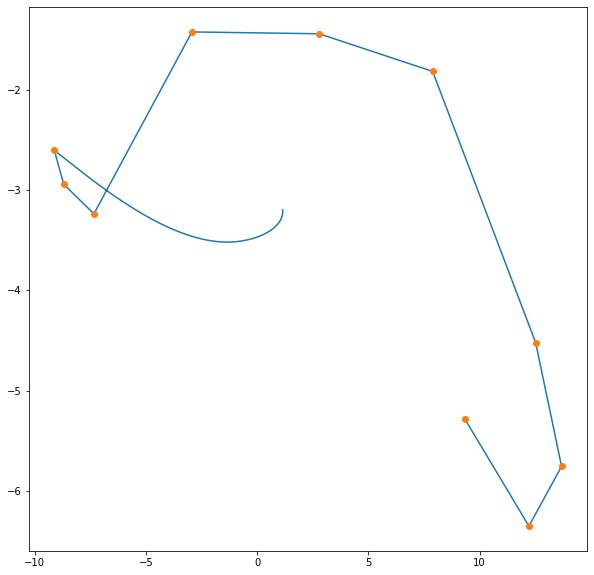

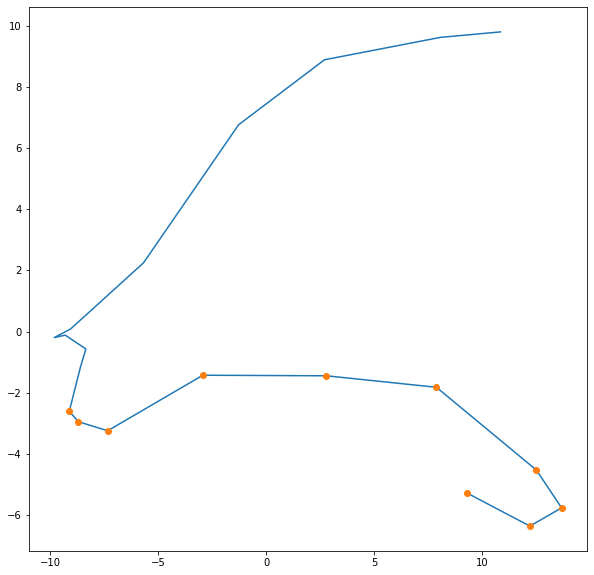

------------------------------ Epoch 540 ------------------------------


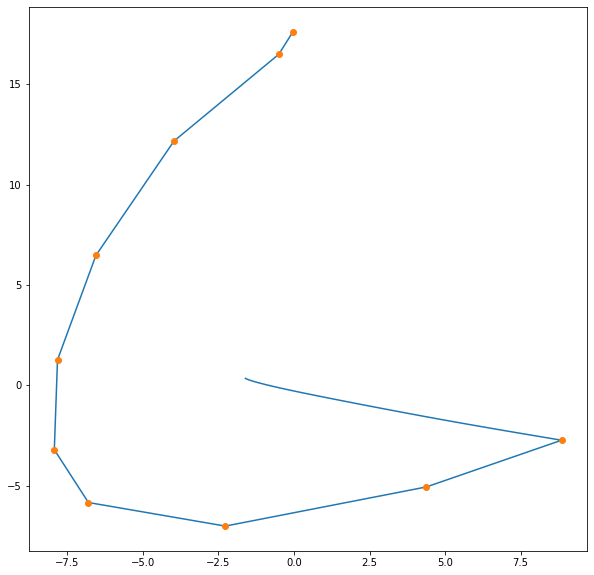

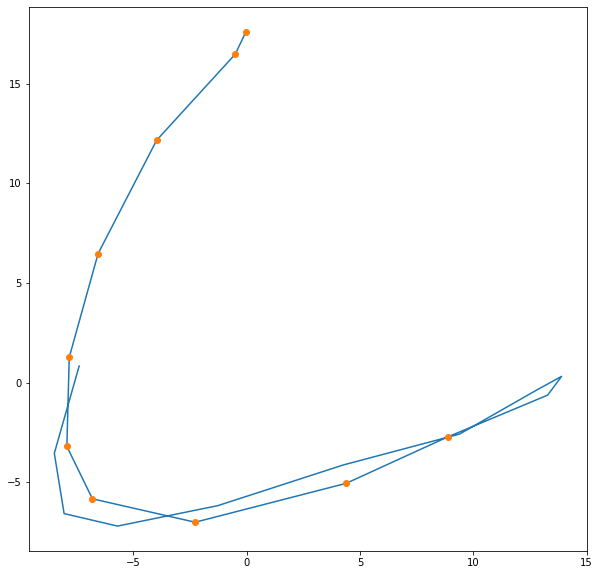

------------------------------ Epoch 570 ------------------------------


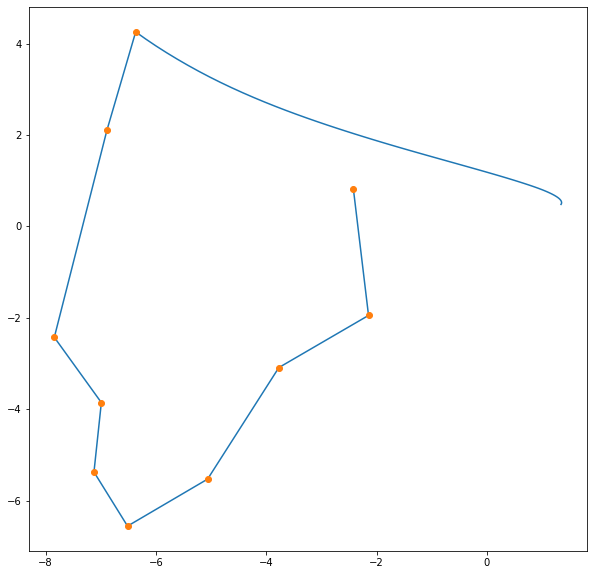

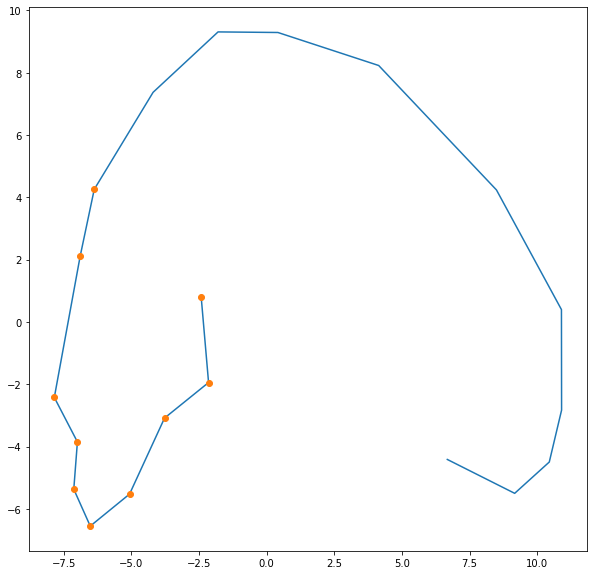

------------------------------ Epoch 600 ------------------------------


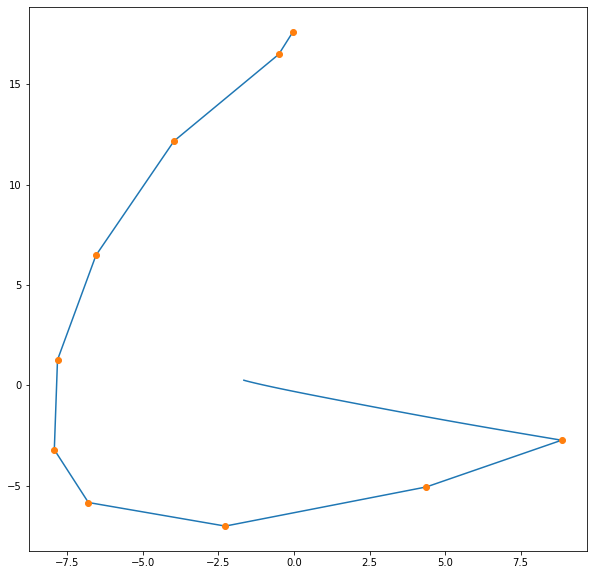

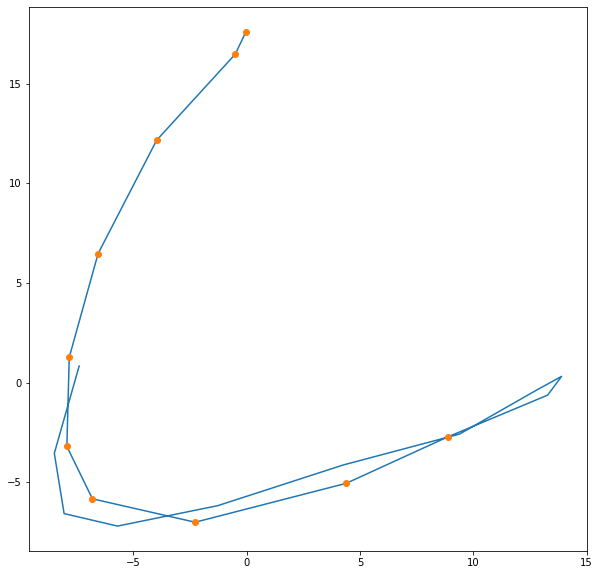

------------------------------ Epoch 630 ------------------------------


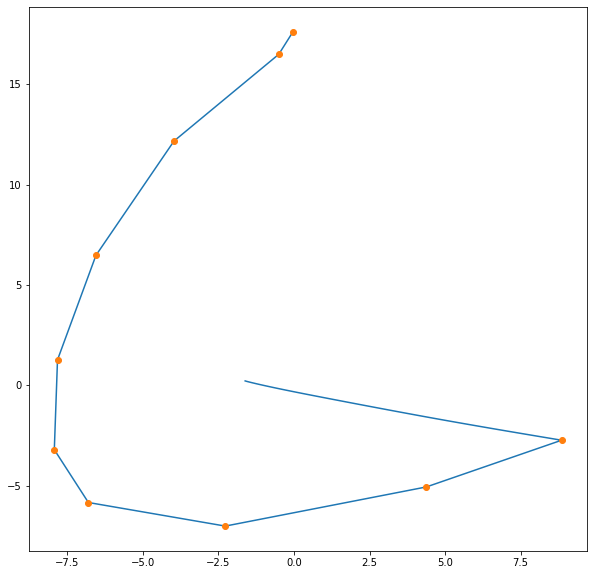

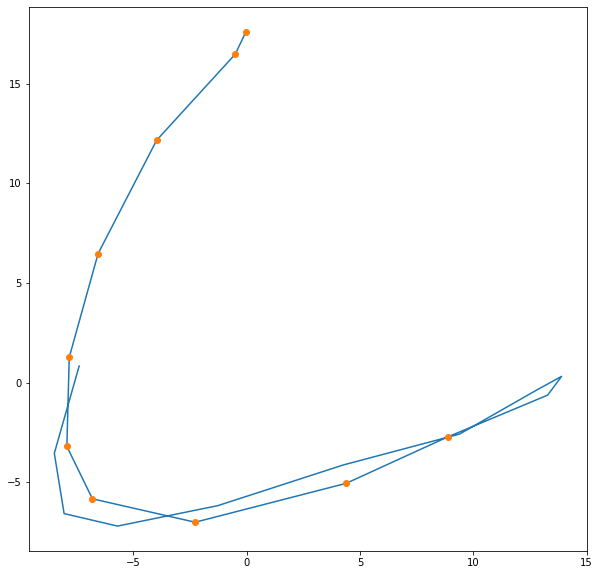

------------------------------ Epoch 660 ------------------------------


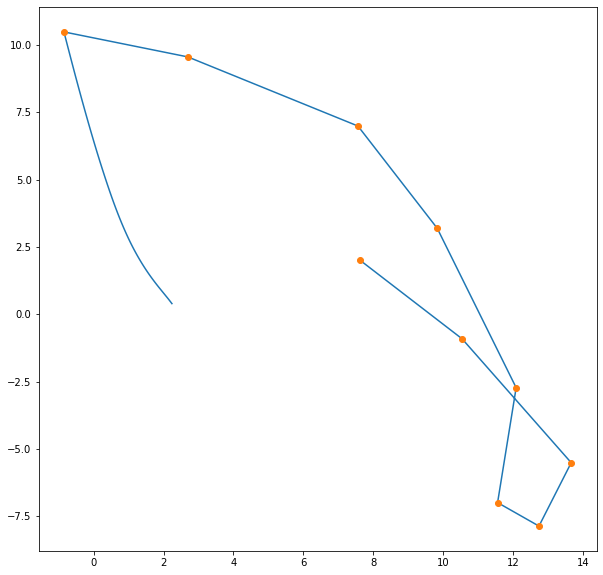

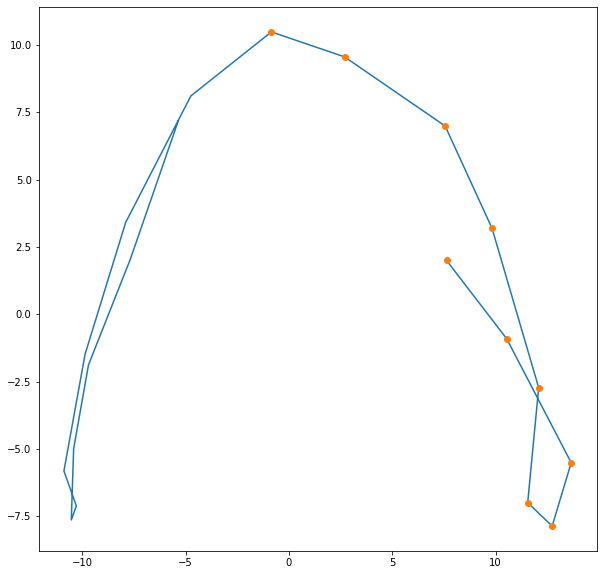

------------------------------ Epoch 690 ------------------------------


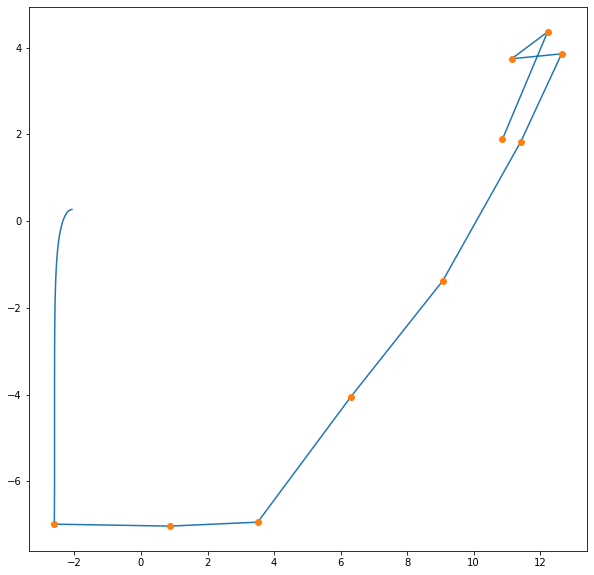

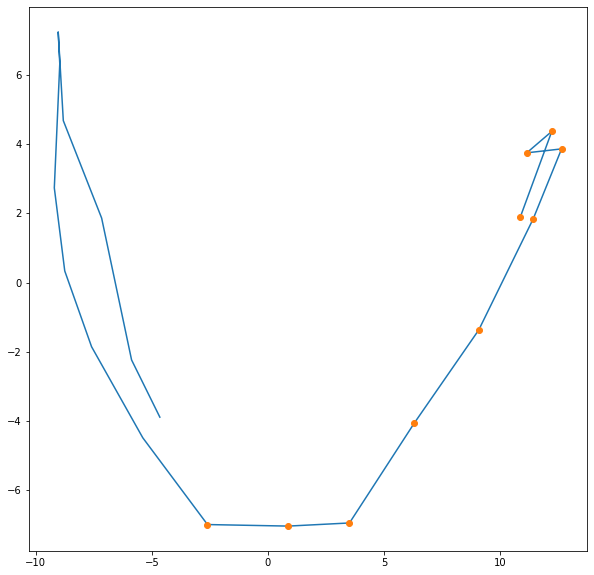

------------------------------ Epoch 720 ------------------------------


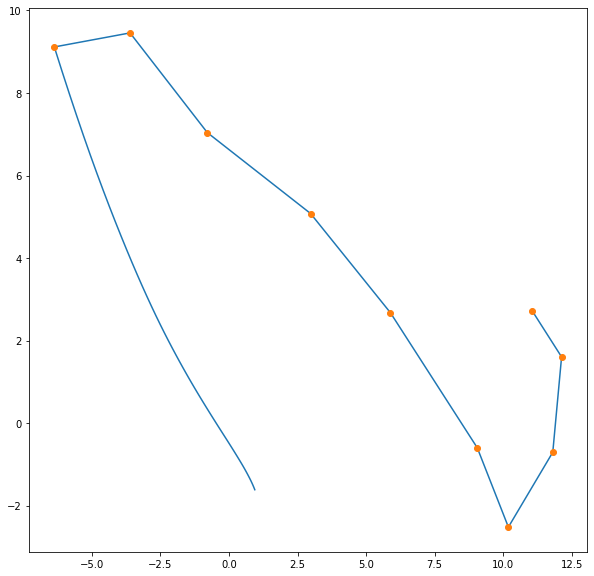

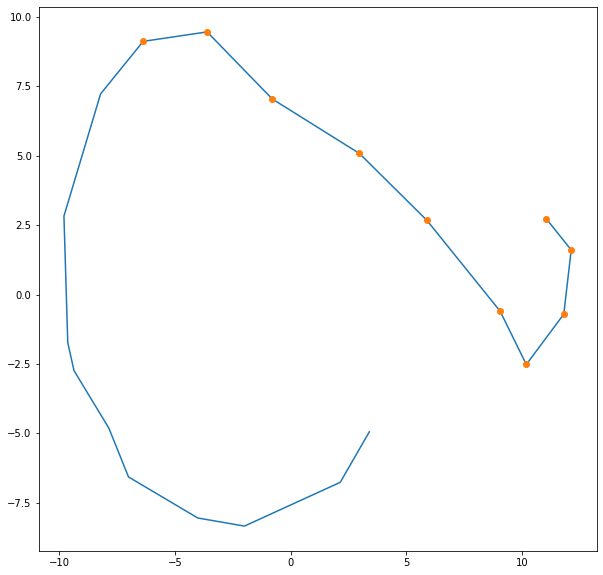

------------------------------ Epoch 750 ------------------------------


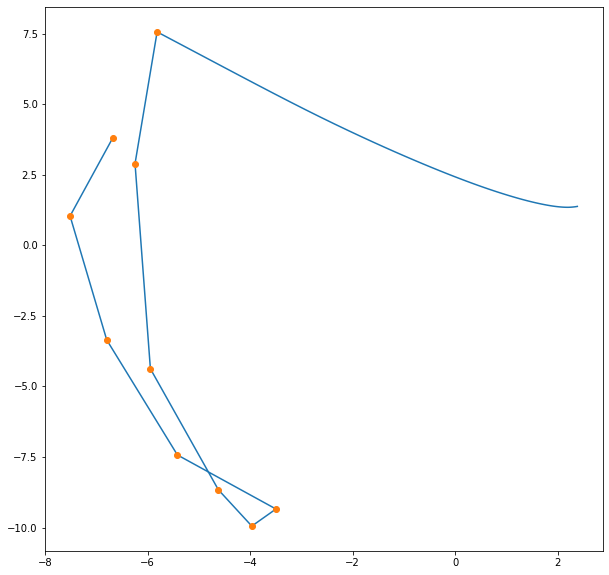

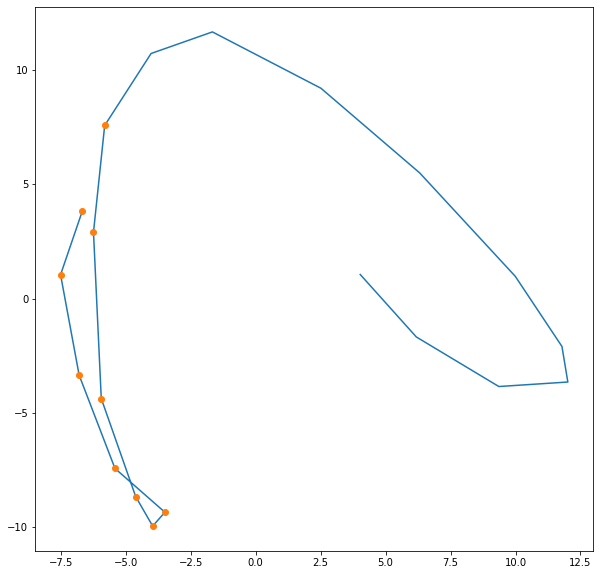

------------------------------ Epoch 780 ------------------------------


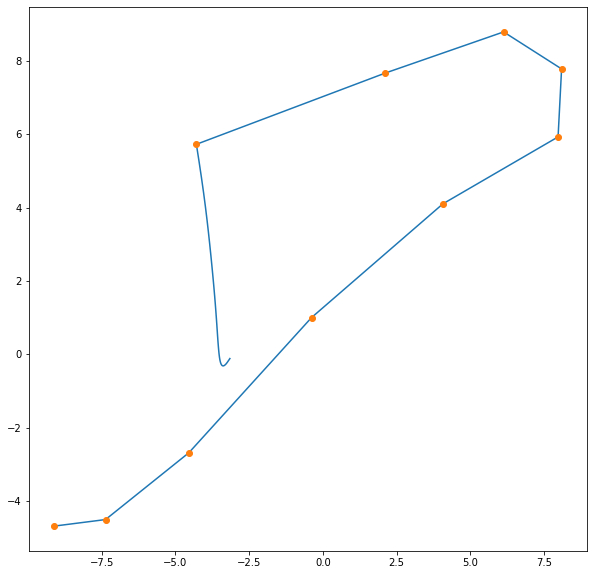

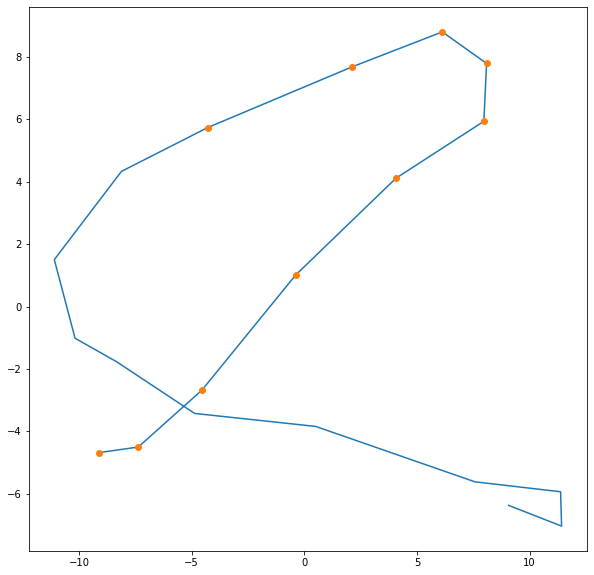

KeyboardInterrupt: 

In [24]:
optimizer = torch.optim.Adam(ode.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
epochs = 1000
batch_size = 96

train(ode, optimizer, scheduler, epochs, batch_size, getter, display=30)

# All together

In [2]:
class LatentODE(nn.Module):
    def __init__(self, height, weight, in_channels, mid_dim, latent_dim, pathAE=pathAE, pathODE=None):
        super(LatentODE, self).__init__()
        self.height = height
        self.weight = weight
        self.in_channels = in_channels
        self.mid_dim = mid_dim
        self.latent_dim = latent_dim
        self.pathAE = pathAE
        self.pathODE = pathODE

        self.ae = ConvAE(latent_dim=latent_dim, height=height, width=weight, in_channels=in_channels)
        self.odenet = ODEnetSimple(out_dim=latent_dim, mid_dim=mid_dim)
        
        if not pathAE is None:
            self.ae.load_state_dict(torch.load(pathAE))

            for param in self.ae.parameters():
                param.requires_grad = False

        if not pathODE is None:
            self.odenet.load_state_dict(torch.load(pathODE))

            for param in self.odenet.parameters():
                param.requires_grad = False


        # count the number of parameters and the number of trainable parameters
        print("-"*30, "Latent ODE model", "-"*30)
        print("Number of parameters: ", sum([p.numel() for p in self.parameters()]))
        print("Trainable parameters: ", sum([p.numel() for p in self.parameters() if p.requires_grad]))

    def forward(self, x, t):

        assert len(x.shape) >= 4, "Input shape must be (batch_size, in_channels, height, width) or (time_steps, batch_size, in_channels, height, width)"

        latent_x = torch.tensor([])

        if len(x.shape) == 4:
            latent_x = self.ae.encode(x)
            
        else:
            for i in range(x.shape[0]):
                latent_x_t = self.ae.encode(x[i])
                latent_x_t = latent_x_t.unsqueeze(0)
                latent_x = torch.cat((latent_x, latent_x_t), 0)

        # print("latent", latent_x.shape)
        # print(latent_x)
        out = self.odenet(latent_x, t)
        # print("out ode shape", out.shape)
        # print(out[1])
        output = torch.tensor([])

        for vec in out:
          output_t = self.ae.decode(vec)
          output_t  = output_t.unsqueeze(1)
          output = torch.cat((output, output_t ), 1)
        return output
    
model = LatentODE(height=28, weight=28, in_channels=3, mid_dim=128, latent_dim=128, pathAE=None, pathODE=None)

NameError: name 'nn' is not defined

In [3]:
class BatchGetter:
    def __init__(self, batch_time, n_samples, total_length, dt, images, frac_train):
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        self.true_images = torch.tensor(images, dtype=torch.float64).float()
        self.N_train = int(images.shape[1]*frac_train)
        self.N_test = int(images.shape[1]*(1-frac_train))

        self.N_train_image = int(images.shape[0])

        self.train_times = self.times[:self.N_train]
        self.test_times = self.times[self.N_train:]
        self.train_images = self.true_images[:, :self.N_train]
        self.test_images = self.true_images[:, self.N_train:]
        # print(self.train_images.shape)


        self.n_samples = n_samples
        self.batch_time = batch_time
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        trajectory_index = np.random.randint(self.N_train)
        # print(trajectory_index)
        s = torch.from_numpy(np.random.choice(np.arange(self.N_train_image - self.batch_time, dtype=np.int64), self.n_samples, replace=True))
        batch_y0 = self.train_images[s, trajectory_index]  # (M, D)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_y = torch.stack([self.train_images[s + i, trajectory_index] for i in range(self.batch_time)], dim=0)  # (T, M, D)
        return batch_y0, batch_t, batch_y

dt = 0.05
batch_time = 2
n_samples = 64

getter = BatchGetter(batch_time, n_samples, moving_mnist.shape[0], dt, moving_mnist, 0.8)

NameError: name 'moving_mnist' is not defined

In [7]:
batch_init_images, batch_times, batch_true_images = getter.get_batch()
print(batch_init_images.shape, batch_times.shape, batch_true_images.shape)
print("init reconstruction", model(batch_init_images, batch_times)[:,:].shape)
print("batch reconstruction", model(batch_true_images, batch_times)[:,:].shape)
print(model.ae.encode(batch_init_images).shape)

torch.Size([64, 3, 28, 28]) torch.Size([2]) torch.Size([2, 64, 3, 28, 28])
init reconstruction torch.Size([64, 2, 3, 28, 28])
batch reconstruction torch.Size([128, 2, 3, 28, 28])
torch.Size([64, 128])


In [8]:
print(batch_init_images.shape, batch_times.shape, batch_true_images.shape)
print("init reconstruction", model(batch_init_images, batch_times).shape)
print("batch reconstruction", model(batch_true_images, batch_times).shape)

torch.Size([64, 3, 28, 28]) torch.Size([2]) torch.Size([2, 64, 3, 28, 28])
init reconstruction torch.Size([64, 2, 3, 28, 28])
batch reconstruction torch.Size([128, 2, 3, 28, 28])


In [9]:
batch_init_images, batch_times, batch_true_images = getter.get_batch()
print(batch_init_images.shape, batch_times.shape, batch_true_images.shape)

print(model.ae.encode(batch_init_images).shape)

torch.Size([64, 3, 28, 28]) torch.Size([2]) torch.Size([2, 64, 3, 28, 28])
torch.Size([64, 128])


In [10]:
index = torch.randint(0, getter.N_train_image, (1,))
input_image = getter.train_images[0, index].unsqueeze(0)
print(input_image.shape)
output_image = model(input_image, getter.train_times)
print(output_image.shape)

torch.Size([1, 1, 3, 28, 28])
torch.Size([1, 20, 3, 28, 28])


In [11]:
res = getter.get_batch()
print(len(res))
print(res[0].shape)
print(res[1].shape)
print(res[2].shape)

3
torch.Size([64, 3, 28, 28])
torch.Size([2])
torch.Size([2, 64, 3, 28, 28])


In [17]:
def train(model, optimizer, scheduler, getter, epochs, batch_size, display=100):
    
    model.train()
    iterator = trange(1, epochs+1)
    # just for the plot part
    for i in iterator:
        loss = 0.
        for _ in range(batch_size):
            # get a random time sample
            batch_init_images, batch_times, batch_true_images = getter.get_batch()
            # compute the output of the model
            out = model(batch_true_images, batch_times)[:,-1]
            # compute the loss
            out_shape = out.shape
            batch_true_images = batch_true_images.reshape(out_shape)

            loss += 100.*F.mse_loss(out, batch_true_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.8f}')

        if i % display == 0:
        #    display_results(i, model, getter, getter.total_length, getter.dt)
            display_results(model, batch_init_images, jumps=10)
            continue

        scheduler.step()
            
    return None


def display_results(model, batch_init_images, jumps=10):

    # print(len(batch_init_images))

    times = torch.linspace(0, 1, int(1/0.01))
    with torch.no_grad():
        out = model(batch_init_images, times)[:1,::jumps].squeeze()
    
    batch_size = len(out)
    
    # print(out.shape)

    # plot all the images
    height_plot = 15
    width_plot = height_plot * int(np.ceil(out.shape[0]/2))
    fig, ax = plt.subplots(figsize=(width_plot,height_plot))
    for i in range(batch_size):
        img = out[i,0]
        plt.subplot(2, batch_size, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
    # for i in range(batch_size):
    #     plt.subplot(2, batch_size, i+1+batch_size)
    #     plt.imshow(input_image[i], cmap='gray')
    #     plt.axis('off')
    plt.show()

    plt.imshow(batch_init_images[0,0])
    plt.show()

    


# number_of_plots = 1
# display_results(model, batch_init_images)

In [18]:
batch_init_images.shape

torch.Size([64, 3, 28, 28])

  0%|          | 0/100 [00:00<?, ?it/s]

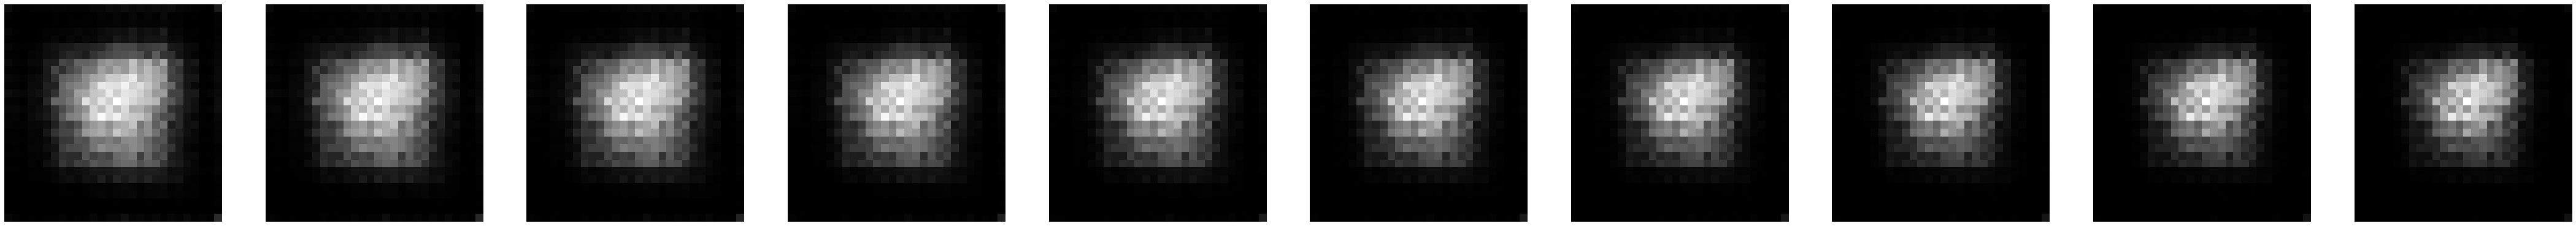

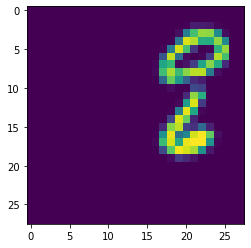

KeyboardInterrupt: 

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
epochs = 100
batch_size = 64

train(model, optimizer, scheduler, getter, epochs, batch_size, display=2)